# IS 843 Final Project

## Name: Zelin (Zack) Zhao

# Data Analysis Question: 

### a) How does the duration (strength) of severe storms affect the Citibike usages in NYC from 2013-2018?

### b) How do the severe storms affect Citibike uses in different stations differently? 

# Data Loading

In [1]:
from pyspark.sql import functions as F
from pyspark.sql.types import (StructType, 
                               StructField, 
                               DateType, 
                               BooleanType,
                               DoubleType,
                               IntegerType,
                               StringType,
                               LongType,
                               FloatType,
                              TimestampType)

### load the citibike_trips table

In [2]:
trips = spark.read.format('bigquery').option('table', 'bigquery-public-data:new_york_citibike.citibike_trips').option('header', "true").load()
trips.printSchema()

root
 |-- tripduration: long (nullable = true)
 |-- starttime: string (nullable = true)
 |-- stoptime: string (nullable = true)
 |-- start_station_id: long (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- end_station_id: long (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: double (nullable = true)
 |-- end_station_longitude: double (nullable = true)
 |-- bikeid: long (nullable = true)
 |-- usertype: string (nullable = true)
 |-- birth_year: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- customer_plan: string (nullable = true)



### load the citibike_stations table

In [3]:
stations = spark.read.format('bigquery').option('table', 'bigquery-public-data:new_york_citibike.citibike_stations').option('header', "true").load()
stations.printSchema()

root
 |-- station_id: string (nullable = false)
 |-- name: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- region_id: long (nullable = true)
 |-- rental_methods: string (nullable = true)
 |-- capacity: long (nullable = true)
 |-- eightd_has_key_dispenser: boolean (nullable = true)
 |-- num_bikes_available: long (nullable = true)
 |-- num_bikes_disabled: long (nullable = true)
 |-- num_docks_available: long (nullable = true)
 |-- num_docks_disabled: long (nullable = true)
 |-- is_installed: boolean (nullable = true)
 |-- is_renting: boolean (nullable = true)
 |-- is_returning: boolean (nullable = true)
 |-- eightd_has_available_keys: boolean (nullable = true)
 |-- last_reported: timestamp (nullable = true)



### load the storms_20** table

In [4]:
storms_2013 = spark.read.format('bigquery').option('table', 'bigquery-public-data.noaa_historic_severe_storms.storms_2013').option('header', "true").load()
storms_2014 = spark.read.format('bigquery').option('table', 'bigquery-public-data.noaa_historic_severe_storms.storms_2014').option('header', "true").load()
storms_2015 = spark.read.format('bigquery').option('table', 'bigquery-public-data.noaa_historic_severe_storms.storms_2015').option('header', "true").load()
storms_2016 = spark.read.format('bigquery').option('table', 'bigquery-public-data.noaa_historic_severe_storms.storms_2016').option('header', "true").load()
storms_2017 = spark.read.format('bigquery').option('table', 'bigquery-public-data.noaa_historic_severe_storms.storms_2017').option('header', "true").load()
storms_2018 = spark.read.format('bigquery').option('table', 'bigquery-public-data.noaa_historic_severe_storms.storms_2018').option('header', "true").load()

In [5]:
storms = storms_2013.union(storms_2014).union(storms_2015).union(storms_2016).union(storms_2017).union(storms_2018)
storms.printSchema()

root
 |-- episode_id: string (nullable = true)
 |-- event_id: string (nullable = true)
 |-- state: string (nullable = true)
 |-- state_fips_code: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- cz_type: string (nullable = true)
 |-- cz_fips_code: string (nullable = true)
 |-- cz_name: string (nullable = true)
 |-- wfo: string (nullable = true)
 |-- event_begin_time: string (nullable = true)
 |-- event_timezone: string (nullable = true)
 |-- event_end_time: string (nullable = true)
 |-- injuries_direct: long (nullable = true)
 |-- injuries_indirect: long (nullable = true)
 |-- deaths_direct: long (nullable = true)
 |-- deaths_indirect: long (nullable = true)
 |-- damage_property: long (nullable = true)
 |-- damage_crops: long (nullable = true)
 |-- source: string (nullable = true)
 |-- magnitude: double (nullable = true)
 |-- magnitude_type: string (nullable = true)
 |-- flood_cause: string (nullable = true)
 |-- tor_f_scale: string (nullable = true)
 |-- tor_len

# Data Cleaning

### Clean the trips Dataframe

In [6]:
trips = trips.withColumn("starttime", F.col("starttime").cast("timestamp"))
trips = trips.withColumn("stoptime", F.col("stoptime").cast("timestamp"))

In [7]:
trips = trips.na.drop(subset=["tripduration","start_station_latitude","start_station_longitude","end_station_latitude","end_station_longitude"])

In [8]:
# FIXME: drop 138 rows out of 53108721
trips = trips.filter((F.col("start_station_latitude") != 0.0) \
                     & (F.col("start_station_longitude") != 0.0) \
                     & (F.col("end_station_latitude") != 0.0) \
                     & (F.col("end_station_longitude") != 0.0))

In [9]:
#FIXME: what is this used for?
#nyc_bikes = nyc_bikes.repartition(20)

In [10]:
trips = trips.drop('end_station_id','end_station_name','end_station_latitude','end_station_longitude','bikeid', 'usertype','birth_year','gender','customer_plan')

In [11]:
trips.printSchema()

root
 |-- tripduration: long (nullable = true)
 |-- starttime: timestamp (nullable = true)
 |-- stoptime: timestamp (nullable = true)
 |-- start_station_id: long (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)



In [12]:
trips.cache()
trips.show()

+------------+--------------------+--------------------+----------------+------------------+----------------------+-----------------------+
|tripduration|           starttime|            stoptime|start_station_id|start_station_name|start_station_latitude|start_station_longitude|
+------------+--------------------+--------------------+----------------+------------------+----------------------+-----------------------+
|        1894| 2014-07-31 23:46:38| 2014-08-01 00:18:12|             520|   W 52 St & 5 Ave|           40.75992262|           -73.97648516|
|         949| 2014-12-11 11:35:12| 2014-12-11 11:51:01|             520|   W 52 St & 5 Ave|           40.75992262|           -73.97648516|
|         660| 2017-07-23 17:58:27| 2017-07-23 18:09:27|             520|   W 52 St & 5 Ave|           40.75992262|           -73.97648516|
|         262| 2015-08-23 11:13:12| 2015-08-23 11:17:34|             520|   W 52 St & 5 Ave|           40.75992262|           -73.97648516|
|         127| 2016-

In [13]:
#trips.describe().show()

### Clean the stations Dataframe

In [14]:
stations = stations.na.drop(subset=["latitude", "longitude"])

In [15]:
stations = stations.filter((F.col("latitude") != 0.0) \
                     & (F.col("longitude") != 0.0))

In [16]:
stations = stations.drop('region_id','rental_methods','capacity','eightd_has_key_dispenser','num_bikes_available','num_bikes_disabled',\
                         'num_docks_available','num_docks_disabled','is_installed','is_renting','is_returning','eightd_has_available_keys','last_reported')

In [17]:
stations.printSchema()

root
 |-- station_id: string (nullable = false)
 |-- name: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- region_id: long (nullable = true)



In [18]:
stations.cache()
stations.show()

+--------------------+--------------------+----------+------------------+------------------+---------+
|          station_id|                name|short_name|          latitude|         longitude|region_id|
+--------------------+--------------------+----------+------------------+------------------+---------+
|7a1ad7c0-4958-435...|       56 Dr & 59 St|   5579.02|          40.72403|         -73.90853|       71|
|66de11bc-0aca-11e...|Wolcott St & Dwig...|   4054.02|        40.6753274|       -74.0100698|       71|
|66dd515d-0aca-11e...|W 74 St & Columbu...|   7230.10|        40.7785669|      -73.97754961|       71|
|66dd1d0f-0aca-11e...|Banker St & Meser...|   5633.04|          40.72606|         -73.95621|       71|
|bfe5e69d-89ff-48b...|       India St Pier|   5794.05|40.731734785883454| -73.9612390102593|       71|
|66db277a-0aca-11e...|St James Pl & Pea...|   5167.06|       40.71117416|      -74.00016545|       71|
|66dd4ec7-0aca-11e...|Riverside Dr & W ...|   7388.10|       40.78720869|

In [132]:
stations.select('station_id').distinct().count()

1906

### Clean the storms Dataframe

In [20]:
storms = storms.withColumn("event_begin_time", F.col("event_begin_time").cast("timestamp"))
storms = storms.withColumn("event_end_time", F.col("event_end_time").cast("timestamp"))

In [21]:
storms = storms.na.drop(subset=["event_begin_time", "event_timezone", "event_end_time", "event_latitude", "event_longitude"])

In [22]:
storms = storms.drop("injuries_direct","injuries_indirect","deaths_direct","deaths_indirect","damage_property","damage_crops","source","flood_cause")
storms = storms.drop('magnitude','magnitude_type','tor_f_scale','tor_length','tor_width','tor_other_wfo','location_index','event_range','event_azimuth','reference_location','event_point'\
                    ,'state','state_fips_code','cz_type','cz_fips_code','cz_name','wfo')

In [23]:
#FIXME: remove storm events where event_end_time is the same as the event_begin_time
storms = storms.filter(~(F.col("event_end_time") == F.col("event_begin_time")))
# storms_in_stations.count()

In [24]:
storms.printSchema()

root
 |-- episode_id: string (nullable = true)
 |-- event_id: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- event_begin_time: timestamp (nullable = true)
 |-- event_timezone: string (nullable = true)
 |-- event_end_time: timestamp (nullable = true)
 |-- event_latitude: double (nullable = true)
 |-- event_longitude: double (nullable = true)



In [25]:
storms.cache()
storms.show()

+----------+--------+----------+-------------------+--------------+-------------------+--------------+---------------+
|episode_id|event_id|event_type|   event_begin_time|event_timezone|     event_end_time|event_latitude|event_longitude|
+----------+--------+----------+-------------------+--------------+-------------------+--------------+---------------+
|     70537|  423603|      hail|2013-01-29 02:15:00|         EST-5|2013-01-29 02:16:00|          41.7|          -86.0|
|     70537|  423604|      hail|2013-01-29 14:00:00|         EST-5|2013-01-29 14:01:00|         41.68|         -85.98|
|     70537|  423605|      hail|2013-01-29 13:50:00|         EST-5|2013-01-29 13:51:00|         41.21|         -86.11|
|     70538|  423602|      hail|2013-01-29 02:40:00|         EST-5|2013-01-29 02:41:00|         41.76|         -85.68|
|     70674|  424291|      hail|2013-01-29 11:16:00|         CST-6|2013-01-29 11:18:00|         32.75|          -98.9|
|     70674|  424292|      hail|2013-01-29 12:45

In [26]:
#storms.describe().show()

# Data Processing

### Assumption 1: if a storm event is in the rectangular area bounded by the minimum and maximum latitudes and longitudes of all stations, then the Citibike usages were under the effect of that storm (could be improved using the postal code)

### Assumption 2: use only the starting station's longitudes and latitudes as the geological location of that bike trip in the Citibike trips table 

In [27]:
lo_lati = stations.select("latitude").orderBy("latitude").collect()[0][0]
hi_lati = stations.select("latitude").orderBy(F.col("latitude").desc()).collect()[0][0]
lo_longi =stations.select("longitude").orderBy("longitude").collect()[0][0]
hi_longi =stations.select("longitude").orderBy(F.col("longitude").desc()).collect()[0][0]

print("latitude:", lo_lati, hi_lati)
print("longitude", lo_longi, hi_longi)

latitude: 40.633385 40.88226
longitude -74.0867006778717 -73.88145


In [28]:
#FIXME: filter the storms based on the rectangular area bounded by the latitudes and longitudes of stations
storms_in_stations = storms.filter(F.col("event_latitude").between(lo_lati, hi_lati) & F.col("event_longitude").between(lo_longi, hi_longi))

In [29]:
# FIXME: find the zip code using the latitude and longitude

# def return_zip(long, lat):
#     Latitude = lat
#     Longitude = long
#     location = geolocator.reverse(Latitude+","+Longitude)
#     address = location.raw['address']
#     return address['postcode']


# postal_code_udf = F.udf(return_zip, DoubleType())

##### (New York state_fips_code: 36) 

In [30]:
# storms = storms.withColumn("postal_code", postal_code_udf(storms.event_longitude, storms.event_latitude))
# trips = trips.withColumn('postal_code', postal_code_udf(trips.start_station_longitude, trips.start_station_latitude))
# stations = stations.withColumn('postal_code', postal_code_udf(stations.longitude, stations.latitude))

In [31]:
# station_postal_codes = stations.select("postal_code").distinct().collect()
# station_postal_codes
# #storms_in_stations = storms.filter(F.col("postal_code").isin(station_postal_codes))

In [32]:
#FIXME: duplicate events of storm in the same episode need to be removed
storms_in_stations = storms_in_stations.dropDuplicates(subset=["episode_id"])
storms_in_stations.count()

29

In [33]:
storms_in_stations = storms_in_stations.withColumn("event_duration_in_sec", F.col("event_end_time").cast(LongType()) - F.col("event_begin_time").cast(LongType()))

In [34]:
storms_in_stations.show()

+----------+--------+-----------+-------------------+--------------+-------------------+--------------+---------------+---------------------+
|episode_id|event_id| event_type|   event_begin_time|event_timezone|     event_end_time|event_latitude|event_longitude|event_duration_in_sec|
+----------+--------+-----------+-------------------+--------------+-------------------+--------------+---------------+---------------------+
|    131099|  784213|flash flood|2018-09-25 11:03:00|         EST-5|2018-09-25 14:30:00|       40.7849|       -74.0468|                12420|
|     76521|  467533|      flood|2013-06-07 22:05:00|         EST-5|2013-06-08 02:30:00|       40.7942|       -73.9547|                15900|
|     84980|  514109|      flood|2014-04-30 21:29:00|         EST-5|2014-04-30 21:59:00|       40.8822|       -74.0822|                 1800|
|     87719|  529219|flash flood|2014-06-13 17:42:00|         EST-5|2014-06-13 18:20:00|       40.6768|       -73.9843|                 2280|
|     

In [35]:
#FIXME: group the events by three types of storms
storms_in_stations_category = storms_in_stations.select("event_type").distinct().show()

+-----------+
| event_type|
+-----------+
|      flood|
|flash flood|
+-----------+



### Inner join the storms_in_stations Dataframe to the trips Dataframe

In [53]:
# FIXME: multiple storms for one trip?
# FIXME: join issues: only used trips rows that are within the storm duration

# stormPassedCond = trips["starttime"] > storms_in_stations["event_end_time"]
# stormNotArrivedCond = trips["stoptime"] < storms_in_stations["event_begin_time"]

# df = trips.join(storms_in_stations, on=(~stormPassedCond | ~stormNotArrivedCond), how="inner")
# df.show()



df = trips.join(storms_in_stations, \
                on=(trips.starttime <= storms_in_stations.event_end_time) & (trips.stoptime >= storms_in_stations.event_begin_time), \
                how="inner")
df.cache()
df.show(30)

+------------+--------------------+--------------------+----------------+--------------------+----------------------+-----------------------+----------+--------+-----------+-------------------+--------------+-------------------+--------------+---------------+---------------------+
|tripduration|           starttime|            stoptime|start_station_id|  start_station_name|start_station_latitude|start_station_longitude|episode_id|event_id| event_type|   event_begin_time|event_timezone|     event_end_time|event_latitude|event_longitude|event_duration_in_sec|
+------------+--------------------+--------------------+----------------+--------------------+----------------------+-----------------------+----------+--------+-----------+-------------------+--------------+-------------------+--------------+---------------+---------------------+
|         637| 2015-07-30 14:14:05| 2015-07-30 14:24:42|             403|      E 2 St & 2 Ave|           40.72502876|           -73.99069656|     98403|  

23/04/29 03:02:07 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


In [38]:
df.printSchema()

root
 |-- tripduration: long (nullable = true)
 |-- starttime: timestamp (nullable = true)
 |-- stoptime: timestamp (nullable = true)
 |-- start_station_id: long (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- episode_id: string (nullable = true)
 |-- event_id: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- event_begin_time: timestamp (nullable = true)
 |-- event_timezone: string (nullable = true)
 |-- event_end_time: timestamp (nullable = true)
 |-- event_latitude: double (nullable = true)
 |-- event_longitude: double (nullable = true)
 |-- event_duration_in_sec: long (nullable = true)
 |-- station_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- region_id: long (nullable = true)



In [39]:
df.count()

18304

# Data Visualization

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

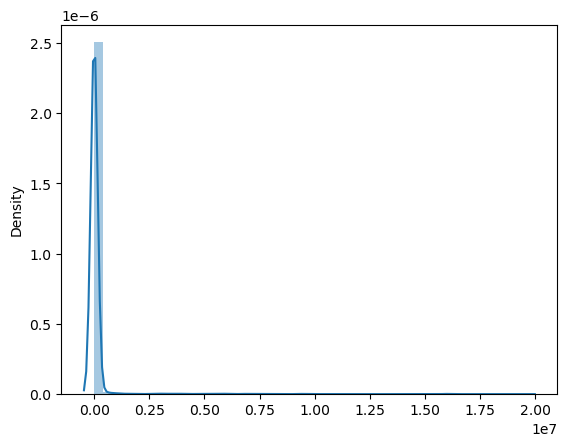

In [41]:
# Sample the dataframe
sample_df = df.select(['tripduration']).sample(withReplacement=False, fraction=.4, seed=42)

# Convert the sample to a Pandas DataFrame
pandas_df = sample_df.toPandas()

# Plot it
sns.distplot(pandas_df)


#### By the distribution plot, we can see that the NYC Citibike usage duration during storms are heavily skewed to the right, meaning that although most Citibike usages during the storm were within short durations, there were many extreme cases with much longer usage durations. 

#### It is also possible that people might leave the Citibike somewhere other than a Citibike station, making the usage time extremely long.

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

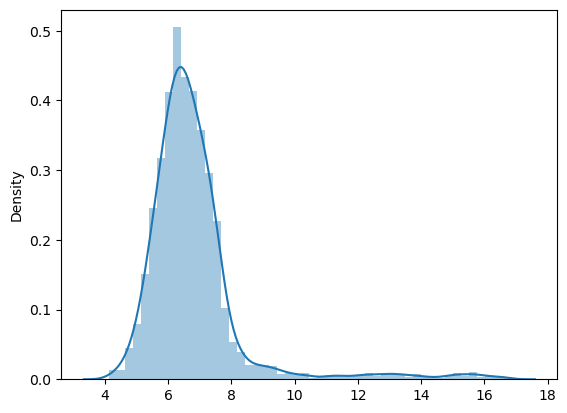

In [42]:
df = df.withColumn("log_tripduration", F.log(df.tripduration))

# Sample the dataframe
sample_df = df.select(['log_tripduration']).sample(withReplacement=False, fraction=.4, seed=42)

# Convert the sample to a Pandas DataFrame
pandas_df = sample_df.toPandas()

# Plot it
sns.distplot(pandas_df)

#### To reduce the skewness of the Citibike usage duration data while maintaining its characteristics, or reduce the extreme cases and make the data distribution to conform to a Normal distribution, so as to make our statistical analysis more valid, we apply a natural log transformation to the Citibike usage time in this case. 

#### We can see from the distribution plot of the log-transformed Citibike usage time data that it becomes more "Normal" now.

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

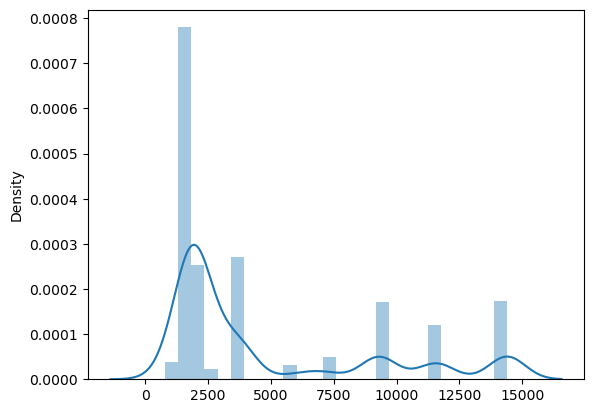

In [43]:
# Sample the dataframe
sample_df = df.select(['event_duration_in_sec']).sample(withReplacement=False, fraction=.4, seed=42)

# Convert the sample to a Pandas DataFrame
pandas_df = sample_df.toPandas()

# Plot it
sns.distplot(pandas_df)


#### We can also plot the distribution plot of the storm event duration to view how the storm event duration data distributes as well.

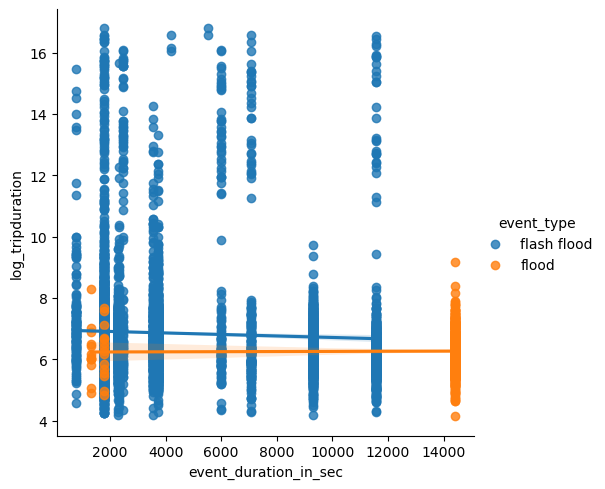

In [44]:
# Select the relevant columns and sample
sample_df = df.select(['event_duration_in_sec', 'log_tripduration', 'event_type']).sample(withReplacement=False, fraction=.4, seed=42)

# Convert to pandas dataframe
pandas_df = sample_df.toPandas()

# Linear model plot of pandas_df
sns.lmplot(x='event_duration_in_sec', y='log_tripduration', hue='event_type', data=pandas_df)
plt.show()

### As seen from the scatterplot, the log-transformed Citibike usage time is negatively correlated with the duration of both flash flood and flood, with the flash flood having a higher correlation coefficient. 

### This means that as the severe storm events like flash flood and flood last longer in NYC, people are less likely to use Citibikes during the storms. 

### We can also see that the duration of flash flood has greater negative impacts on the NYC Citibike usages than duration of flood. Flash floods have a sudden and rapid impact on the affected areas, which can cause immediate disruptions to transportation systems, including Citibike usage. The quick onset of flash floods might force riders to change their plans and adapt quickly, which could lead to stronger correlations between flash flood duration and Citibike trip duration.

### Finally we can conclude that Citibike usage tends to decline as the duration of severe storms increases, although people might choose to ride a Citibike less during a storm regardless of the storm's intensity.

## Part b: Do storms impact Citibike trips from all stations equally in NYC during 2013-2017?

### 1) Leave out the stations with trips less than 10 to reduce bias

### 2) Separate the stations into quartiles according to the number of trips

### 3) Compute the mean of potential decrease in trip durations for quartiles of stations during storms

#### Count the number of distinct stations affected under the storm

In [45]:
df.select(['start_station_id']).distinct().count()

678

#### Create columns of avg and count to represent the average trip dutation and number of trip duration for the station that the trip belongs to

#### Count the number of trips whose starting stations have number of trips larger than 10 during the storm

In [88]:
from pyspark.sql.window import Window
from pyspark.sql.functions import count,col,avg,sum,min,max,ceil

windowSpecAgg  = Window.partitionBy("start_station_id")
df = df.withColumn("count", count(col("tripduration")).over(windowSpecAgg)) \
  .where(col("count") > 10)

df.cache()
df.count()

ImportError: cannot import name 'median' from 'pyspark.sql.functions' (/usr/lib/spark/python/pyspark/sql/functions.py)

In [69]:
df.printSchema()

root
 |-- tripduration: long (nullable = true)
 |-- starttime: timestamp (nullable = true)
 |-- stoptime: timestamp (nullable = true)
 |-- start_station_id: long (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- episode_id: string (nullable = true)
 |-- event_id: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- event_begin_time: timestamp (nullable = true)
 |-- event_timezone: string (nullable = true)
 |-- event_end_time: timestamp (nullable = true)
 |-- event_latitude: double (nullable = true)
 |-- event_longitude: double (nullable = true)
 |-- event_duration_in_sec: long (nullable = true)
 |-- avg: double (nullable = true)
 |-- count: long (nullable = false)



#### Count the number of stations with trips more than 10 during historical storm events

In [70]:
df.select("start_station_id").where(col("count") > 10).distinct().count()

338

#### The maximum number of trip for a station

In [73]:
max_count = df.select(col("count")).orderBy(col("count").desc()).collect()[0][0]
max_count

188

#### Find the cutoffs for the quartiles regarding number of trips

In [79]:
from pyspark.sql import DataFrameStatFunctions as statFunc

quantiles = statFunc(df).approxQuantile("count", [0.25, 0.5, 0.75], 0.0)
q1, q2, q3 = quantiles

quantiles

[44.0, 63.0, 85.0]

#### Find the quartiles by the number of trips during storm events

In [81]:
from pyspark.sql.functions import col, when

df = df.withColumn("quartile",
                            when(col("count") <= q1, "Q1")
                            .when((col("count") > q1) & (col("count") <= q2), "Q2")
                            .when((col("count") > q2) & (col("count") <= q3), "Q3")
                            .otherwise("Q4"))
df.printSchema()

root
 |-- tripduration: long (nullable = true)
 |-- starttime: timestamp (nullable = true)
 |-- stoptime: timestamp (nullable = true)
 |-- start_station_id: long (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- episode_id: string (nullable = true)
 |-- event_id: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- event_begin_time: timestamp (nullable = true)
 |-- event_timezone: string (nullable = true)
 |-- event_end_time: timestamp (nullable = true)
 |-- event_latitude: double (nullable = true)
 |-- event_longitude: double (nullable = true)
 |-- event_duration_in_sec: long (nullable = true)
 |-- avg: double (nullable = true)
 |-- count: long (nullable = false)
 |-- quartile: string (nullable = false)



#### Median trip duration in each quartile

In [128]:
from pyspark.sql.functions import sum, avg, max, count, col, percentile_approx

quartile_group_df = df.groupBy("quartile") \
    .agg(percentile_approx("tripduration", 0.5).alias("median_dur")) \
    .orderBy(col("quartile").asc())

quartile_group_df.show()

+--------+----------+
|quartile|median_dur|
+--------+----------+
|      Q1|       763|
|      Q2|       670|
|      Q3|       622|
|      Q4|       676|
+--------+----------+



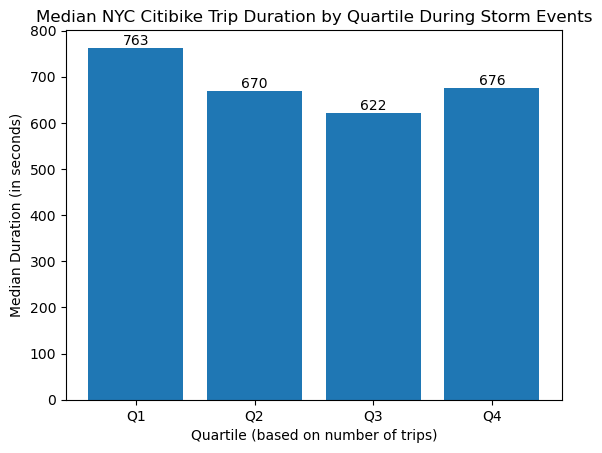

In [130]:
import matplotlib.pyplot as plt

pandas_df = quartile_group_df.select("quartile", "median_dur").toPandas()

fig, ax = plt.subplots()

# Set the x-axis and y-axis data
bars = ax.bar(pandas_df['quartile'], pandas_df['median_dur'])

# Set the labels for the x-axis and y-axis
ax.set_xlabel('Quartile (based on number of trips)')
ax.set_ylabel('Median Duration (in seconds)')

# Set the title for the plot
ax.set_title('Median NYC Citibike Trip Duration by Quartile During Storm Events')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')


# Show the plot
plt.show()

#### Median trip duration in each quartile from the trips dataframe whether there is a storm or not

In [109]:
q1_id_rows = df.select("start_station_id").where(col('quartile') == 'Q1').distinct().collect()
q1_id_list = [row.start_station_id for row in q1_id_rows]

filtered_trips = trips.where(col("start_station_id").isin(q1_id_list))
trips_q1_median_dur = filtered_trips.select(percentile_approx("tripduration", 0.5)).collect()[0][0]

trips_q1_median_dur

665

In [110]:
q2_id_rows = df.select("start_station_id").where(col('quartile') == 'Q2').distinct().collect()
q2_id_list = [row.start_station_id for row in q2_id_rows]

filtered_trips = trips.where(col("start_station_id").isin(q2_id_list))
trips_q2_median_dur = filtered_trips.select(percentile_approx("tripduration", 0.5)).collect()[0][0]

trips_q2_median_dur

615

In [111]:
q3_id_rows = df.select("start_station_id").where(col('quartile') == 'Q3').distinct().collect()
q3_id_list = [row.start_station_id for row in q3_id_rows]

filtered_trips = trips.where(col("start_station_id").isin(q3_id_list))
trips_q3_median_dur = filtered_trips.select(percentile_approx("tripduration", 0.5)).collect()[0][0]

trips_q3_median_dur

592

In [112]:
q4_id_rows = df.select("start_station_id").where(col('quartile') == 'Q4').distinct().collect()
q4_id_list = [row.start_station_id for row in q4_id_rows]

filtered_trips = trips.where(col("start_station_id").isin(q4_id_list))
trips_q4_median_dur = filtered_trips.select(percentile_approx("tripduration", 0.5)).collect()[0][0]

trips_q4_median_dur

633

In [119]:
data = [("Q1", trips_q1_median_dur),
        ("Q2", trips_q2_median_dur),
        ("Q3", trips_q3_median_dur),
        ("Q4", trips_q4_median_dur)]
columns = ["quartile", "median_dur"]

trips_median_dur_df = spark.createDataFrame(data, columns)
trips_median_dur_df.show()

+--------+----------+
|quartile|median_dur|
+--------+----------+
|      Q1|       665|
|      Q2|       615|
|      Q3|       592|
|      Q4|       633|
+--------+----------+



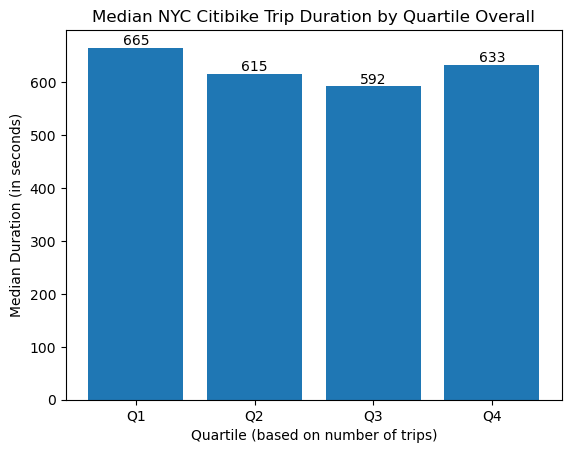

In [131]:
import matplotlib.pyplot as plt

pandas_df = trips_median_dur_df.select("quartile", "median_dur").toPandas()

fig, ax = plt.subplots()

# Set the x-axis and y-axis data
bars = ax.bar(pandas_df['quartile'], pandas_df['median_dur'])

# Set the labels for the x-axis and y-axis
ax.set_xlabel('Quartile (based on number of trips)')
ax.set_ylabel('Median Duration (in seconds)')

# Set the title for the plot
ax.set_title('Median NYC Citibike Trip Duration by Quartile Overall')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')


# Show the plot
plt.show()

## Conclusions of Part b: Do storms impact Citibike trips from all stations equally in NYC during 2013-2017?

## 1) The storms did impact Citibike trips from all stations roughly equally in NYC during 2013-2017. 

### The number of Citibike stations that are potentially under the storm impacts in NYC is 678; after I left out stations with less than 10 trips, the number of stations was reduced to 338, still too large to be fit onto one graph. Therefore, In the data analysis, I defined the quartiles of bike stations by the number of trips starting from that station and get four divisions of bike stations. Besides, to view the average pattern in the quartiles of stations, I chose the median over mean, because the median of trip durations is less susceptible to outliers compared to the mean. 

### As we can see from the two bar plots together, whether during storms or overall, the four median Citibike trip durations remained in the same order: Q1 being the longest, Q4 being the second, Q2 being the third, and Q4 being the shortest. Besides, the four median bike trip durations all slightly increase during storm events compared to the results overall, which are kind of counter-intuitive at first but are left open to explanations. 

#### a) Self-selection of riders: During a severe storm, only a small subset of riders may choose to use Citibike. These riders may have higher tolerance for adverse weather conditions, have a stronger need to reach their destination, or be more experienced cyclists. As a result, they might take longer trips compared to the average user in normal weather conditions.

#### b) Reduced alternatives: In severe storm conditions, public transportation such as subways and buses might experience delays, reduced frequency, or even temporary shutdowns. Taxis and rideshares might also be less available or have higher prices due to increased demand. This could lead some people to choose Citibike as a mode of transportation and take longer trips than they would otherwise.

#### c) Navigational challenges: During a severe storm, visibility may be reduced, streets might be flooded, and there may be fallen trees or debris blocking the usual routes. Riders might need to take detours or travel at a slower pace, leading to longer trip durations.

#### d) Availability of bikes and docking stations: Due to fewer people using Citibike during severe storms, bikes and docking stations might be more available, making it more convenient for users to take longer trips without worrying about finding a docking station at their destination.

## 2) The two longest median Citibike trip durations came from stations with the lowest and highest number of trips. And this discovery can be explained in several different ways.

#### a) Station location and demographics: Stations with the lowest number of bike trips might be located in less densely populated areas or areas with fewer points of interest, such as parks or recreational facilities. Users starting their trips from these stations may be more likely to engage in leisurely activities or longer exercise routines, leading to longer trip durations. On the other hand, stations with the highest number of bike trips might be located in busy urban areas, close to popular destinations, where people are more likely to use Citibike for commuting or running errands. These users might take slightly longer trips to reach their destinations due to factors like traffic, congestion, or longer distances between points of interest.

#### b) Availability of bikes and docking stations: Stations with a lower number of bike trips might have higher availability of bikes and docking stations. This could encourage users to take longer trips without worrying about finding a docking station at their destination. Conversely, stations with a higher number of bike trips might have limited availability of bikes and docking stations. Users starting their trips from these stations might be more inclined to take longer trips to avoid the hassle of finding a docking station in a congested area.